In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26ee06c00b8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [12]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26ee06c0ef0>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

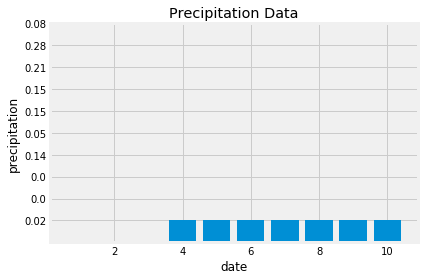

In [13]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute("SELECT * FROM Measurement WHERE date >= '2016-08-12T00:00:00.000'").fetchall()
# Calculate the date 1 year ago from the last data point in the database
engine.execute("SELECT * FROM Measurement ORDER BY date DESC").fetchall()
# Perform a query to retrieve the data and precipitation scores
engine.execute("SELECT date, prcp FROM Measurement WHERE date >= '2016-08-12T00:00:00.000' ORDER BY date ASC").fetchall()
# Save the query results as a Pandas DataFrame and set the index to the date column
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).all()
df = pd.DataFrame(data=results)
# Sort the dataframe by date
date = [result[0] for result in results[:10]]
prcp = [result[1] for result in results[:10]]
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ypos = range(1, len(date)+1)
ax.bar(ypos, date[::-1])
ax.set_xlabel("date")
ax.set_ylabel("precipitation")
ax.set_yticks(ypos)
ax.set_yticklabels(prcp[::-1])
ax.set_title("Precipitation Data")
fig.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prp_data = [func.count(Measurement.prcp), func.avg(Measurement.prcp), func.min(Measurement.prcp), func.max(Measurement.prcp)]

prp_data2 = session.query(*prp_data).all()
prp_data2

[(18103, 0.16064353974479206, 0.0, 11.53)]

![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
engine.execute("SELECT COUNT(station) FROM Station").fetchall()

[(9,)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("SELECT station, count(*) FROM Measurement GROUP BY station ORDER BY count(*) DESC").fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute("SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM Measurement WHERE station = 'USC00519281'").fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = engine.execute("SELECT tobs FROM Measurement WHERE station = 'USC00519281' GROUP BY tobs ORDER BY COUNT(*) DESC ").fetchall()
counts = engine.execute("SELECT COUNT(tobs) FROM Measurement WHERE station = 'USC00519281' GROUP BY tobs ORDER BY COUNT(*) DESC ").fetchall()
engine.execute("SELECT tobs, COUNT(tobs) FROM Measurement WHERE station = 'USC00519281' GROUP BY tobs ORDER BY COUNT(*) DESC ").fetchall()


[(72.0, 290),
 (73.0, 278),
 (71.0, 265),
 (74.0, 261),
 (70.0, 227),
 (75.0, 204),
 (69.0, 193),
 (76.0, 148),
 (68.0, 143),
 (67.0, 111),
 (77.0, 111),
 (78.0, 88),
 (66.0, 80),
 (65.0, 71),
 (79.0, 54),
 (80.0, 43),
 (64.0, 41),
 (62.0, 37),
 (63.0, 33),
 (81.0, 22),
 (61.0, 19),
 (60.0, 15),
 (82.0, 11),
 (57.0, 6),
 (58.0, 6),
 (59.0, 5),
 (56.0, 4),
 (83.0, 3),
 (54.0, 1),
 (84.0, 1),
 (85.0, 1)]

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-01-01', '2018-01-01'))

[(58.0, 74.14387974230493, 87.0)]


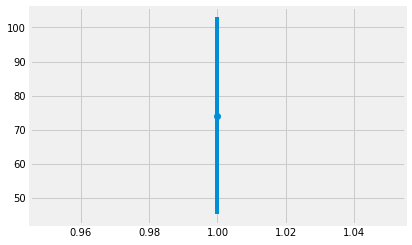

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp = calc_temps('2017-01-01', '2018-01-01')

#print(temp[0][1])
peak = temp[0][2] - temp[0][0]
plt.errorbar(1, temp[0][1], yerr=peak, fmt='o')
plt.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
engine.execute("SELECT Measurement.station, name, latitude, longitude, elevation, COUNT(prcp) FROM Measurement JOIN Station ON Measurement.station=Station.station GROUP BY prcp ").fetchall()


[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 8185),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1198),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 966),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 707),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 483),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 466),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 375),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 308),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 312),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 230),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 297),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 179),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
